# 3D Flex: Custom Latent Trajectory

```{note}
[Read the tutorial](https://guide.cryosparc.com/processing-data/tutorials-and-case-studies/tutorial-3d-flexible-refinement) to learn more about 3D Flexible Refinement.
```

This example covers the following:

* Load particle latent coordinates from a 3D Flex Training job
* Plot the latent coordinates
* Interactively draw a trajectory through the latent space
* Output the trajectory as a new output in CryoSPARC

The resulting trajectory may be used as input to the 3D Flex Generator job to generate a volume series along the trajectory. In this way, you can visualize specific regions or pathways through the latent conformational distribution of the particle.

In [1]:
import numpy as n
from cryosparc.tools import CryoSPARC
from pathlib import Path
import json

with open(Path("~", "instance-info.json").expanduser(), "r") as f:
    credentials = json.load(f)

cs = CryoSPARC(**credentials)
assert cs.test_connection()

Connection succeeded to CryoSPARC command_core at http://cryoem0.sbi:40002
Connection succeeded to CryoSPARC command_vis at http://cryoem0.sbi:40003
Connection succeeded to CryoSPARC command_rtp at http://cryoem0.sbi:40005


Load the particles dataset from the 3D Flex Training job.

In [2]:
import pandas as pd

project = cs.find_project("P251")
particles = project.find_job("J21").load_output("particles")

# only display the first ten rows, since creating an entire dataframe is slow
pd.DataFrame(particles.rows()[:10])

,components_mode_0/component,components_mode_0/value,components_mode_1/component,components_mode_1/value,uid
0,0,0.016000,1,0.314667,3070975014664207456
1,0,-0.122667,1,-0.293333,4618435520677801850
2,0,-0.496000,1,0.048000,5473205460946538064
3,0,0.357333,1,0.133333,16310523440862460071
4,0,0.698667,1,0.048000,13340786341065263892
5,0,-0.464000,1,0.645333,7620063338136754589
6,0,0.261333,1,0.624000,8503060922953376810
7,0,-0.389333,1,0.240000,5615192081528122837
8,0,0.506667,1,0.090667,11043336177950782473
9,0,-0.890667,1,0.410667,16147356686061724833


Create an interative plot that responds to on-click events. 

Once the plot is drawn, click repeatedly on the plot along a trajectory you wish to sample in the latent space. The points along this trajectory will form the output of the notebook and be used in 3D Flex Generator.

```{note}
Using interactive plots in Jupyter Notebooks can present some challenges.
Connecting to a remote VS Code remote notebook requires the ipympl package
and the `%matplotlib widget` "magic" line.
See [the matplotlib documentation](https://matplotlib.org/stable/users/explain/figure/interactive.html)
for more detail.
```

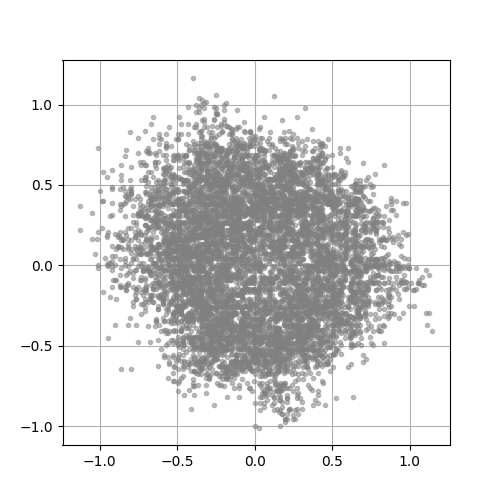

In [4]:
%matplotlib widget
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(5, 5))


def do_plot():
    plt.plot(
        particles["components_mode_0/value"][::10],
        particles["components_mode_1/value"][::10],
        ".",
        alpha=0.5,
        color="gray",
    )
    plt.grid()


do_plot()

chain = True
pts = []


def onclick(event):
    fig.clf()
    do_plot()
    pts.append([event.xdata, event.ydata])
    apts = n.array(pts)
    if chain:
        plt.plot(apts[0, 0], apts[0, 1], "xk")
        plt.plot(apts[:, 0], apts[:, 1], ".-r")
    else:
        for k, i in enumerate(range(0, len(apts), 2)):
            plt.plot(apts[i, 0], apts[i, 1], "xk")
            plt.plot(apts[i : i + 2, 0], apts[i : i + 2, 1], ".-", label=str(k))
        plt.legend()


cid = plt.gcf().canvas.mpl_connect("button_press_event", onclick)

![custom-trajectory.png](attachments/custom-trajectory.png)

Print out the selected trajectory points.

In [5]:
latent_pts = n.array(pts)
for pt in latent_pts:
    print(f"{pt[0]:5.2f}, {pt[1]:5.2f}")

-0.26,  0.52
-0.49,  0.10
-0.29, -0.33
 0.22, -0.46
 0.67, -0.12
 0.42,  0.27
-0.04,  0.27
-0.27, -0.01


Set up an external job to save the custom latent components. Connect to the train job to ensure output fields get passed through.

In [6]:
job = project.create_external_job("W4", "Custom Latents")
slot_spec = [{"dtype": "components", "prefix": f"components_mode_{k}", "required": True} for k in range(2)]
job.connect("particles", "J21", "particles", slots=slot_spec)

Add and allocate an output for the job to store the custom latent components.

In [7]:
latents_dset = job.add_output(
    type="particle",
    name="latents",
    slots=[{"prefix": "components_mode_%d" % k, "dtype": "components", "required": True} for k in range(2)],
    title="Latents",
    alloc=len(latent_pts),
)

Save the points into the allocated dataset.

In [8]:
for k in range(2):
    latents_dset["components_mode_%d/component" % k] = k
    latents_dset["components_mode_%d/value" % k] = latent_pts[:, k]

Save the output.

In [9]:
with job.run():
    job.save_output("latents", latents_dset)